In [1]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
# Folders to labels
folders = {
    'Mild Dementia': 1,
    'Moderate Dementia': 1,
    'Very mild Dementia': 1,
    'Non Dementia': 0
}

data = []
base_path = 'Oasis_Data'

# Loop through each folder in your directory mapping
for folder, label in folders.items():
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            data.append({
                'file_path': os.path.join(folder_path, file),
                'label': label
            })

df = pd.DataFrame(data)
print(df.head(10))
print(df.shape)
print(df['label'].value_counts())

                                           file_path  label
0  Oasis_Data/Mild Dementia/OAS1_0137_MR1_mpr-3_1...      1
1  Oasis_Data/Mild Dementia/OAS1_0291_MR1_mpr-3_1...      1
2  Oasis_Data/Mild Dementia/OAS1_0278_MR1_mpr-2_1...      1
3  Oasis_Data/Mild Dementia/OAS1_0382_MR1_mpr-4_1...      1
4  Oasis_Data/Mild Dementia/OAS1_0316_MR1_mpr-1_1...      1
5  Oasis_Data/Mild Dementia/OAS1_0316_MR1_mpr-1_1...      1
6  Oasis_Data/Mild Dementia/OAS1_0278_MR1_mpr-2_1...      1
7  Oasis_Data/Mild Dementia/OAS1_0382_MR1_mpr-4_1...      1
8  Oasis_Data/Mild Dementia/OAS1_0052_MR1_mpr-4_1...      1
9  Oasis_Data/Mild Dementia/OAS1_0291_MR1_mpr-3_1...      1
(86437, 2)
label
0    67222
1    19215
Name: count, dtype: int64


In [3]:
class BalancedMRIDataset(Dataset):
    def __init__(self, dataframe, transform=None, mode='train'):
        self.dataframe = dataframe
        self.transform = transform
        self.mode = mode
        if mode == 'train':
            self.demented_df = dataframe[dataframe['label'] == 1]
            self.nondemented_df = dataframe[dataframe['label'] == 0]
            self.oversample_size = len(self.nondemented_df) - len(self.demented_df)

    def __len__(self):
        if self.mode == 'train':
            return 2 * len(self.nondemented_df)  # Ensuring balanced classes in training
        else:
            return len(self.dataframe)

    def __getitem__(self, idx):
        if self.mode == 'train' and idx >= len(self.nondemented_df):
            # Handle augmented demented images
            idx = idx - len(self.nondemented_df)
            row = self.demented_df.iloc[idx % len(self.demented_df)]
            label = 1
        else:
            row = self.dataframe.iloc[idx]
            label = row['label']
        
        img_path = row['file_path']
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [4]:
# Splitting the dataset
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['label'], random_state=42)  # 0.25 x 0.8 = 0.2

In [5]:
# Defining transformations
transformations = transforms.Compose([
    transforms.Resize(50),
    transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augment_transformations = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize(50),
    transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [6]:
# Create datasets
train_dataset = BalancedMRIDataset(train_df, transform=augment_transformations, mode='train')
val_dataset = BalancedMRIDataset(val_df, transform=transformations, mode='validate')
test_dataset = BalancedMRIDataset(test_df, transform=transformations, mode='test')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [7]:
def get_dataset_info(loader):
    label_count = {0: 0, 1: 0}
    for images, labels in loader:
        print("Batch image shape:", images.shape)
        for label in labels:
            label_count[int(label)] += 1
        break  # Remove this line if you want to go through the whole dataset
    print("Label counts:", label_count)

# Call the function with your DataLoader
get_dataset_info(train_loader)
get_dataset_info(val_loader)
get_dataset_info(test_loader)


Batch image shape: torch.Size([16, 1, 80, 80])
Label counts: {0: 9, 1: 7}
Batch image shape: torch.Size([16, 1, 80, 80])
Label counts: {0: 12, 1: 4}
Batch image shape: torch.Size([16, 1, 80, 80])
Label counts: {0: 13, 1: 3}


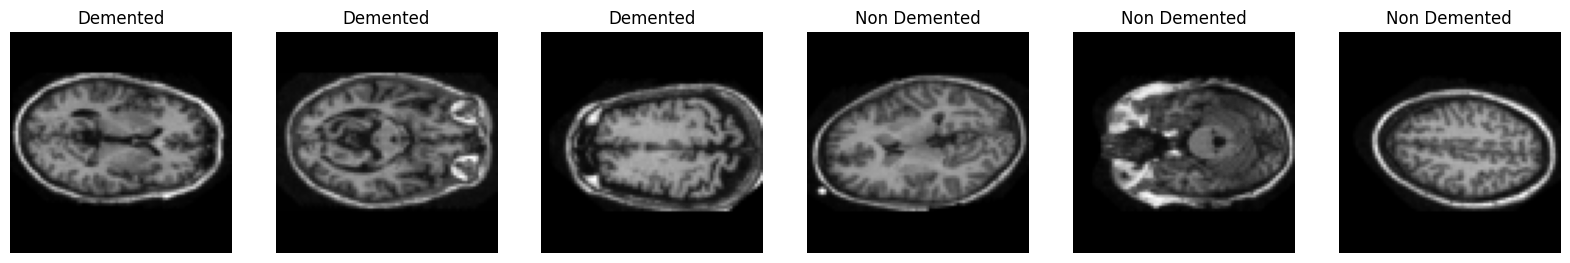

In [8]:
def show_images_with_labels(loader, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    found_non_demented = 0
    found_demented = 0
    
    for images, labels in loader:
        for i, (image, label) in enumerate(zip(images, labels)):
            if (label == 0 and found_non_demented < num_images // 2) or (label == 1 and found_demented < num_images // 2):
                ax = axes[found_non_demented + found_demented]
                img = image.numpy()
                img = np.transpose(img, (1, 2, 0))
                ax.imshow(img * 0.5 + 0.5, cmap='gray')  # Unnormalize
                label_text = 'Non Demented' if label == 0 else 'Demented'
                ax.set_title(label_text)
                ax.axis('off')
                if label == 0:
                    found_non_demented += 1
                else:
                    found_demented += 1
            if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
                break
        if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
            break

show_images_with_labels(train_loader, 6)


# Model

In [9]:
import jax
import jaxlib

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_mnist_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
from quantum_transformers.quantum_layer import get_circuit

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [10]:
for d in jax.devices():
    print(d, d.device_kind)

TFRT_CPU_0 cpu


In [11]:
model = VisionTransformer(
    num_classes=2,  # Keep binary classification
    patch_size=40,
    hidden_size=6,  # Reduce model complexity
    num_heads=2,  # Reduce number of heads
    num_transformer_blocks=6,  # Reduce the depth
    mlp_hidden_size=4,  # Reduce MLP block size
    quantum_attn_circuit=get_circuit(),
    quantum_mlp_circuit=get_circuit(),
    pos_embedding='learn'  # Positional embedding
)

# model = VisionTransformer(
#     num_classes=2,  # Keep binary classification
#     patch_size=96,
#     hidden_size=4,  # Reduce model complexity
#     num_heads=2,  # Reduce number of heads
#     num_transformer_blocks=2,  # Reduce the depth
#     mlp_hidden_size=2,  # Reduce MLP block size
#     quantum_attn_circuit=get_circuit(),
#     quantum_mlp_circuit=get_circuit(),
#     pos_embedding='learn'  # Positional embedding
# )

In [12]:
num_classes = 2  # binary classification
num_epochs = 30  # number of epochs

# Call the train_and_evaluate function with the adjusted parameters
test_loss, test_auc, test_fpr, test_tpr, all_logits, all_labels = train_and_evaluate(
    model=model, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    test_dataloader=test_loader, 
    num_classes=num_classes,
    num_epochs=num_epochs,
)


{'params': {'Conv_0': {'bias': (6,), 'kernel': (40, 40, 1, 6)}, 'Dense_0': {'bias': (2,), 'kernel': (6, 2)}, 'LayerNorm_0': {'bias': (6,), 'scale': (6,)}, 'TransformerBlock_0': {'FeedForward_0': {'Dense_0': {'bias': (4,), 'kernel': (6, 4)}, 'Dense_1': {'bias': (6,), 'kernel': (4, 6)}, 'QuantumLayer_0': {'w': (1, 4)}}, 'LayerNorm_0': {'bias': (6,), 'scale': (6,)}, 'LayerNorm_1': {'bias': (6,), 'scale': (6,)}, 'MultiHeadSelfAttention_0': {'QuantumLayer_0': {'w': (1, 6)}, 'QuantumLayer_1': {'w': (1, 6)}, 'QuantumLayer_2': {'w': (1, 6)}, 'QuantumLayer_3': {'w': (1, 6)}}}, 'TransformerBlock_1': {'FeedForward_0': {'Dense_0': {'bias': (4,), 'kernel': (6, 4)}, 'Dense_1': {'bias': (6,), 'kernel': (4, 6)}, 'QuantumLayer_0': {'w': (1, 4)}}, 'LayerNorm_0': {'bias': (6,), 'scale': (6,)}, 'LayerNorm_1': {'bias': (6,), 'scale': (6,)}, 'MultiHeadSelfAttention_0': {'QuantumLayer_0': {'w': (1, 6)}, 'QuantumLayer_1': {'w': (1, 6)}, 'QuantumLayer_2': {'w': (1, 6)}, 'QuantumLayer_3': {'w': (1, 6)}}}, 'Tran

Epoch   1/30:   0%|          | 0/5042 [00:00<?, ?batch/s]2024-02-23 14:58:23.502171: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-02-23 15:01:18.566999: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m55.068199s

********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch   1/30: 100%|█████████▉| 5041/5042 [14:37<00:00,  9.84batch/s]  2024-02-23 15:16:11.572549: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 5m8.517389s

********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run w

Epoch 1 completed. Validation Loss: 0.8520, Validation AUC: 75.6592%


Epoch   2/30: 100%|██████████| 5042/5042 [10:35<00:00,  7.93batch/s, Loss = 0.9205, AUC = 76.2528%]


Epoch 2 completed. Validation Loss: 0.9205, Validation AUC: 76.2528%


Epoch   3/30: 100%|██████████| 5042/5042 [10:43<00:00,  7.83batch/s, Loss = 0.7600, AUC = 76.9734%]


Epoch 3 completed. Validation Loss: 0.7600, Validation AUC: 76.9734%


Epoch   4/30: 100%|██████████| 5042/5042 [10:43<00:00,  7.84batch/s, Loss = 0.7049, AUC = 77.2818%]


Epoch 4 completed. Validation Loss: 0.7049, Validation AUC: 77.2818%


Epoch   5/30: 100%|██████████| 5042/5042 [10:41<00:00,  7.86batch/s, Loss = 0.7136, AUC = 77.5561%]


Epoch 5 completed. Validation Loss: 0.7136, Validation AUC: 77.5561%


Epoch   6/30: 100%|██████████| 5042/5042 [10:42<00:00,  7.85batch/s, Loss = 0.7200, AUC = 77.7264%]


Epoch 6 completed. Validation Loss: 0.7200, Validation AUC: 77.7264%


Epoch   7/30: 100%|██████████| 5042/5042 [11:55<00:00,  7.05batch/s, Loss = 0.7390, AUC = 78.0474%]


Epoch 7 completed. Validation Loss: 0.7390, Validation AUC: 78.0474%


Epoch   8/30: 100%|██████████| 5042/5042 [12:50<00:00,  6.54batch/s, Loss = 0.6905, AUC = 78.1610%]


Epoch 8 completed. Validation Loss: 0.6905, Validation AUC: 78.1610%


Epoch   9/30: 100%|██████████| 5042/5042 [12:41<00:00,  6.62batch/s, Loss = 0.7508, AUC = 78.4233%]


Epoch 9 completed. Validation Loss: 0.7508, Validation AUC: 78.4233%


Epoch  10/30:  67%|██████▋   | 3354/5042 [07:27<03:34,  7.88batch/s]

In [ ]:
import pickle
with open('mri_oasis_test.pkl', 'wb') as f:
    pickle.dump((test_fpr, test_tpr, test_auc / 100), f)

In [ ]:
from sklearn.metrics import classification_report

# Assuming binary classification with logits as probabilities
predicted_labels = (all_logits > 0.5).astype(int)

# For binary classification with raw scores or multi-class classification
# predicted_labels = np.argmax(all_logits, axis=1)

true_labels = all_labels

print(classification_report(true_labels, predicted_labels))


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(test_fpr, test_tpr, color='darkorange', label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
plt.savefig()
